<a href="https://colab.research.google.com/github/heugyu/coin_deep_learning/blob/master/BTC_LSTM_30M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [2]:
# 구글 드라이브 csv read
data = pd.read_csv('/content/drive/My Drive/DATA/BITFINEX_BTCUSD_30.csv')
print(f'데이터 shape : {data.shape}')
data.head()

데이터 shape : (20595, 51)


,time,open,high,low,close,H,M,L,wca,RES,SUP,Shapes,Shapes.1,EMA_34,EMA_90,EMA_100,EMA_144,EMA_200,short_line,RES.1,RES_CLOSE,SUP.1,SUP_CLOSE,VWAP,34 EMA,Volume,Volume MA,Bitfinex (USD),Coinbase (USD),Bitstamp (USD),Kraken (USD),HitBTC (USD),CEX.io (USD),Binance (USDT),Bittrex (USDT),Poloniex (USDT),bitFlyer (JPY),Bithumb (KRW),Korbit (KRW),Kraken (EUR),Bitfinex (EUR),Bitstamp (EUR),Coinbase (EUR),Volume.1,A/D Volume,Volume EMA,A/D Volume EMA,A/D Buy MA,A/D Sell MA,OnBalanceVolume,MF
0,1546300800,3832.628624,3834.7,3822.4,3825.700000,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3827.600000,3907.376655,73.915970,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,7.277663e+07,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
1,1546302600,3825.400000,3846.2,3825.4,3835.163503,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3833.362781,3907.376655,191.438842,NaN,281986.104243,471690.242938,53461.434513,97501.503149,6.015500e+05,4539.742391,556595.919539,682211.568591,13034.602432,158165.900801,42326.439309,13382.341968,0.0,0.0,0.0,0.0,8.162056e+07,3.504991e+08,NaN,NaN,NaN,NaN,191.438842,NaN
2,1546304400,3835.048699,3840.1,3829.1,3836.000000,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3833.936376,3907.376655,134.660957,NaN,24468.054856,539042.459667,66284.057841,55638.907464,1.157268e+05,1249.574648,288713.845355,617043.314632,513.174804,141868.331003,11911.365126,6678.837282,0.0,0.0,0.0,0.0,8.406477e+07,2.603046e+08,NaN,NaN,NaN,NaN,326.099798,NaN
3,1546306200,3836.000000,3836.0,3819.0,3829.146138,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3831.721047,3902.906339,241.308732,NaN,381339.766270,969347.627364,59551.379977,126904.040255,1.413740e+06,6401.100627,740411.945840,610202.979849,1798.315332,100867.958246,85810.845015,43062.813839,0.0,0.0,0.0,0.0,1.040063e+08,5.586281e+08,NaN,NaN,NaN,NaN,84.791066,NaN
4,1546308000,3827.600000,3834.2,3813.6,3824.100000,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3829.862839,3902.906339,202.116555,NaN,153153.402136,120549.011488,148759.085652,112555.861957,4.467239e+05,305.020229,501386.821625,802029.326660,4482.229082,58746.352479,26173.741498,7317.778965,0.0,0.0,0.0,0.0,8.810634e+07,2.599938e+08,NaN,NaN,NaN,NaN,-117.325489,NaN


In [3]:

print(len(data))

copy_data = data[['open', 'high', 'low', 'close', 'H', 'M', 'L', 'RES', 'SUP','EMA_34', 
                  'short_line', 'VWAP', '34 EMA', 'Volume', 'Volume.1', 'A/D Volume', 
                  'OnBalanceVolume', 'MF']].dropna()

print(len(copy_data))

20595
20547


In [4]:
#   MINMAX scale
    #   가격 
    #   볼륨
    #   OBV
    #   MF
copy_data.head()

,open,high,low,close,H,M,L,RES,SUP,EMA_34,short_line,VWAP,34 EMA,Volume,Volume.1,A/D Volume,OnBalanceVolume,MF
34,3831.92922,3843.4,3831.92922,3834.700000,3866.907127,3847.635379,3828.363631,0.0,0.0,3840.650471,2167.952496,3844.100052,3882.558422,118.056410,3.471785e+07,5.071767e+07,1170.750609,-0.146694
35,3834.70000,3834.7,3824.00000,3827.300000,3866.552462,3846.912593,3827.272724,0.0,0.0,3839.887587,2304.394502,3843.699630,3879.400798,159.362841,7.551339e+07,2.840402e+08,1011.387768,-0.170236
36,3828.00000,3828.5,3812.00000,3823.200000,3866.167244,3844.810893,3823.454543,0.0,0.0,3838.934011,2436.283879,3843.097770,3879.400798,169.077964,6.013885e+07,4.049030e+08,842.309805,-0.208677
37,3823.10000,3824.9,3788.10000,3798.380753,3865.691917,3840.153912,3814.615907,0.0,0.0,3836.616681,2561.054719,3839.749392,3879.400798,587.744334,1.820490e+08,1.077691e+09,254.565471,-0.230207
38,3798.20000,3817.0,3797.10000,3812.281913,3865.188545,3837.712737,3810.236930,0.0,0.0,3835.226123,2676.648607,3839.373825,3879.400798,84.731355,6.035177e+07,2.876835e+08,339.296826,-0.210459


In [5]:

#   스케일러 설정 
price_scaler = MinMaxScaler()
vol_scaler = MinMaxScaler()
obv_scaler = MinMaxScaler()
mf_scaler = MinMaxScaler()

#   스케일 데이터 fitting
price_scaler.fit(np.array(copy_data[['open', 'high', 'low', 'close', 'H', 'M', 'L', 'RES', 'SUP', 'EMA_34', 'short_line', 'VWAP', '34 EMA']]).reshape(-1, 1))
vol_scaler.fit(np.array(copy_data[['Volume', 'Volume.1', 'A/D Volume']]).reshape(-1, 1))
obv_scaler.fit(np.array(copy_data[['OnBalanceVolume']]).reshape(-1, 1))
mf_scaler.fit(np.array(copy_data[['MF']]).reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [6]:
#   학습데이터 0 ~ 1 스케일 
copy_data[['open', 'high', 'low', 'close', 'H', 'M', 'L', 'RES', 'SUP', 'EMA_34', 'short_line', 'VWAP', '34 EMA']] = price_scaler.transform(np.array(copy_data[['open', 'high', 'low', 'close', 'H', 'M', 'L', 'RES', 'SUP', 'EMA_34', 'short_line', 'VWAP', '34 EMA']]).reshape(-1, 13))
copy_data[['Volume', 'Volume.1', 'A/D Volume']] = vol_scaler.transform(np.array(copy_data[['Volume', 'Volume.1', 'A/D Volume']]).reshape(-1, 3))
copy_data[['OnBalanceVolume']] = obv_scaler.transform(np.array(copy_data[['OnBalanceVolume']]).reshape(-1, 1))
copy_data[['MF']] = mf_scaler.transform(np.array(copy_data[['MF']]).reshape(-1, 1))

print(len(copy_data.columns) - 1)
copy_data.head()

17


,open,high,low,close,H,M,L,RES,SUP,EMA_34,short_line,VWAP,34 EMA,Volume,Volume.1,A/D Volume,OnBalanceVolume,MF
34,0.278402,0.279236,0.278402,0.278604,0.280944,0.279543,0.278143,0.0,0.0,0.279036,0.157509,0.279287,0.282081,6.218486e-11,0.000018,0.000027,0.332053,0.387974
35,0.278604,0.278604,0.277826,0.278066,0.280918,0.279491,0.278064,0.0,0.0,0.278980,0.167422,0.279257,0.281851,8.394328e-11,0.000040,0.000150,0.330703,0.371774
36,0.278117,0.278153,0.276954,0.277768,0.280890,0.279338,0.277787,0.0,0.0,0.278911,0.177004,0.279214,0.281851,8.906079e-11,0.000032,0.000213,0.329271,0.345322
37,0.277761,0.277892,0.275218,0.275965,0.280855,0.279000,0.277144,0.0,0.0,0.278743,0.186069,0.278970,0.281851,3.095960e-10,0.000096,0.000568,0.324292,0.330506
38,0.275952,0.277318,0.275872,0.276975,0.280819,0.278822,0.276826,0.0,0.0,0.278642,0.194467,0.278943,0.281851,4.463067e-11,0.000032,0.000152,0.325010,0.344095


In [18]:
copy_data.describe()

,open,high,low,close,H,M,L,RES,SUP,EMA_34,short_line,VWAP,34 EMA,Volume,Volume.1,A/D Volume,OnBalanceVolume,MF
count,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,2.054700e+04,20547.000000,2.054700e+04,20547.000000,20547.000000
mean,0.555177,0.556813,0.553442,0.555194,0.571212,0.554702,0.538191,0.580733,0.498583,0.554896,0.555131,0.447407,0.554059,1.120885e-10,0.000179,1.469293e-03,0.377839,0.506626
std,0.180570,0.181441,0.179591,0.180560,0.188798,0.180402,0.172501,0.196224,0.181078,0.180475,0.180876,0.125720,0.180331,2.208584e-10,0.000222,1.028367e-02,0.235261,0.117699
min,0.249041,0.249760,0.247408,0.249034,0.252569,0.250091,0.247612,0.000000,0.000000,0.250075,0.157509,0.271338,0.251236,0.000000e+00,0.000011,3.994499e-08,0.000000,0.000000
25%,0.384776,0.385542,0.384051,0.384873,0.393656,0.383990,0.377567,0.386486,0.291507,0.384426,0.384587,0.297897,0.381753,2.230525e-11,0.000066,2.643829e-04,0.180296,0.427380
50%,0.588332,0.589793,0.586792,0.588353,0.602326,0.587872,0.573076,0.631866,0.541485,0.588155,0.588429,0.505093,0.588563,4.954499e-11,0.000117,6.390323e-04,0.342605,0.508108
75%,0.698642,0.700465,0.696738,0.698616,0.720193,0.700321,0.681231,0.703487,0.628451,0.698772,0.699115,0.541914,0.702764,1.135187e-10,0.000206,1.406102e-03,0.606297,0.584486
max,0.997457,1.000000,0.986123,0.997384,0.990653,0.919526,0.883674,0.943621,0.814298,0.937081,0.947130,0.660064,0.899892,5.113202e-09,0.005295,1.000000e+00,1.000000,1.000000


In [0]:
#   하이퍼 파라미터 설정 
EPOCHS = 1000
INPUT_SIZE = 18     # input dimension
HIDDEN_SIZE = 36    # hidden dimension
BATCH_SIZE = 64
LENGTH = 14
LR = 0.01

In [27]:
#   학습 데이터 생성
x = np.array(copy_data)
y = np.array(copy_data[['close']])

x_data = []
y_data = []

for i in range(0, len(y) - LENGTH):
    _x = x[i : i + LENGTH]
    _y = y[i + LENGTH]
    # print(f'{_x} -> {_y}')
    x_data.append(_x)
    y_data.append(_y)

#   train/test split
train_size = int(len(y_data) * 0.8)
test_size = len(y_data) - train_size

#   학습 데이터 텐서로 변형
x_all = torch.Tensor(np.array(x_data))
y_all = torch.Tensor(np.array(y_data))

x_train = torch.Tensor(np.array(x_data[0:train_size]))
y_train = torch.Tensor(np.array(y_data[0:train_size]))
x_test = torch.Tensor(np.array(x_data[train_size:len(x_data)]))
y_test = torch.Tensor(np.array(y_data[train_size:len(y_data)]))

x_all = Variable(x_all)
y_all = Variable(y_all)

x_train = Variable(x_train)
y_train = Variable(y_train)
x_test = Variable(x_test)
y_test = Variable(y_test)


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([16426, 14, 18])
torch.Size([16426, 1])
torch.Size([4107, 14, 18])
torch.Size([4107, 1])


In [0]:
# LSTM 

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
                input_size=input_size, 
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
                )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Intitialize hidden and cell states
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagte inpur through LSTM
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

In [29]:

# Instantiate RNN model
lstm = LSTM(5, INPUT_SIZE, HIDDEN_SIZE, 1, LENGTH)

# Set loss and optimizer function
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=LR)

# Train the model
for epoch in range(EPOCHS + 1):
    outputs = lstm(x_train)
    optimizer.zero_grad()

    #obtain the loss function
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        print(f'Epoch : {epoch}, loss : {loss.data.item()}')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([16426, 1])) that is different to the input size (torch.Size([16426, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch : 0, loss : 0.4741188585758209
Epoch : 100, loss : 0.0001957945933099836
Epoch : 200, loss : 0.0001303444878431037
Epoch : 300, loss : 9.787519957171753e-05
Epoch : 400, loss : 7.687750621698797e-05
Epoch : 500, loss : 6.302837573457509e-05
Epoch : 600, loss : 5.363586751627736e-05
Epoch : 700, loss : 4.6876666601747274e-05
Epoch : 800, loss : 4.15841604990419e-05
Epoch : 900, loss : 3.711258614202961e-05
Epoch : 1000, loss : 3.709427619469352e-05


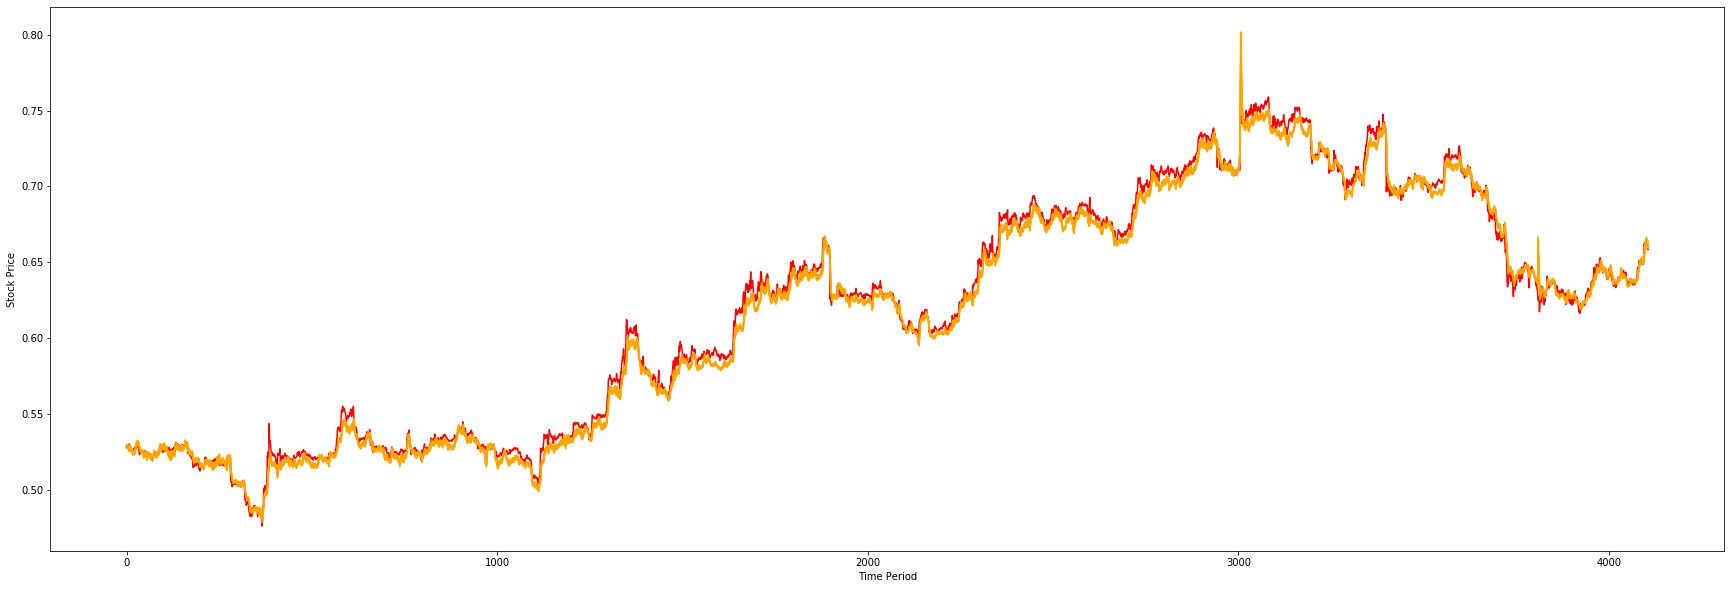

In [34]:
# Test the model
lstm.eval()
test_predict = lstm(x_test)

# Plot predictions
test_predict = test_predict.data.numpy()
real_y = y_test.data.numpy()
plt.figure(figsize=(30, 10))
plt.plot(real_y, color='r')
plt.plot(test_predict, color='orange')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

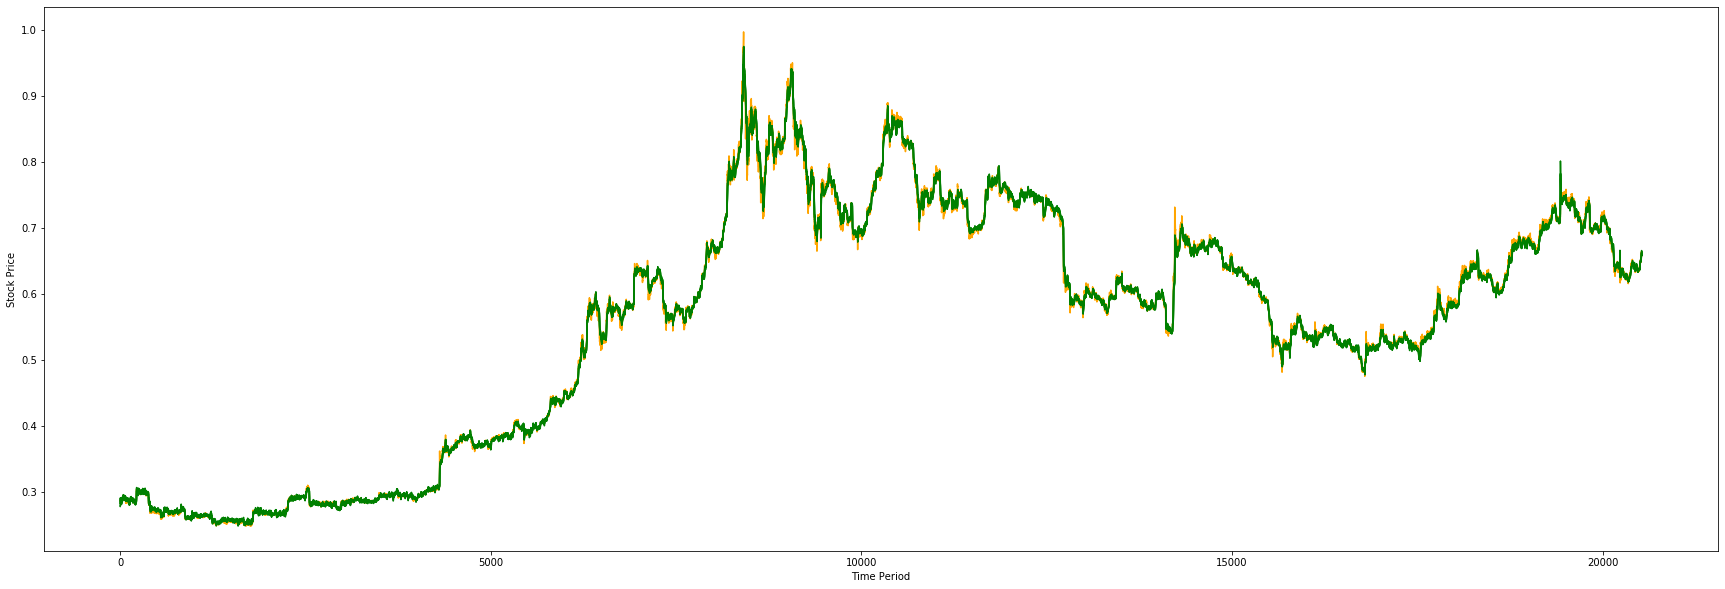

In [33]:
# Test the model
lstm.eval()
test_predict = lstm(x_all)

# Plot predictions
test_predict = test_predict.data.numpy()
real_y = y_all.data.numpy()
plt.figure(figsize=(30, 10))
plt.plot(real_y, color='orange')
plt.plot(test_predict, color='g')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()